# Предсказание цены недвижимости в России

In [25]:
import numpy  as np
import pandas as pd

df_train = pd.read_csv("data/raw/train.csv")

## Предобработка

### Локации

У каждой записи имеется множество значений, обозначающих одни и те же данные: город (`city`), ближайший город (`osm_city_nearest_name`), регион (`region`), улица (`street`), геолокация (`lat`, `lng`) и расстояние до ближайшего города (`osm_city_closest_dist`).

In [26]:
import matplotlib.pyplot as plt

regions = df_train["region"].value_counts()
print("* Статистика локаций:")
print(f"Кол-во улиц     {len(df_train['street'].value_counts())}")
print(f"Кол-во городов  {len(df_train['city'].value_counts())}")
print(f"Кол-во регионов {len(regions)}")

# convert cathegorical sign to a value
def convert_sign(df, sign, new_sign):
    signs = df[sign].value_counts()
    df[new_sign] = df[sign].map(lambda a: signs.index.get_indexer([a])[0])
    return df

* Статистика локаций:
Кол-во улиц     24559
Кол-во городов  4431
Кол-во регионов 49


Исключим избыточные данные, оставив только наиболее полезные: регион и геолокацию.

### Этажи

Рассмотрим распределение этажности недвижимости и долю пропущенных данных.

* Доля недостающих данных: 0.63


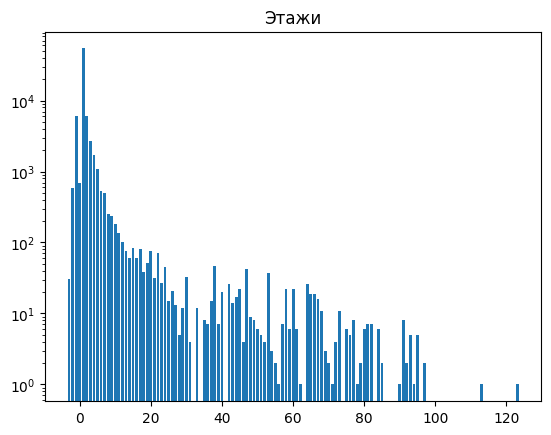

In [27]:
print(f"* Доля недостающих данных: {round(df_train.floor.isna().sum() / len(df_train), 2)}")
floors = df_train.floor.value_counts()

plt.title("Этажи")
plt.yscale("log")
plt.bar(floors.index, floors)
plt.show()

### Даты + Ставка по ипотеке

Преобразуем даты в графу месяцев. Добавим новую графу из внешнего источника: ставку по ипотеке в данный месяц.

In [15]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

def load_mortgages() -> pd.Series:
    # load mortgage statistics page
    page = requests.get("https://frankrg.com/data-hub/category/mortgage/chart/29497")
    page.encoding = page.apparent_encoding
    parsed_html = BeautifulSoup(page.text)

    # load info table
    dates, values = [], []
    table = parsed_html.body.find("tbody", attrs={"class" : "svelte-fe8u5m"})
    for row in table.findChildren("tr"):
        elems = [x.getText().strip().replace(',', '.') for x in row.findChildren("td")]
        dates.append(datetime.strptime(elems[0], "%d.%m.%Y"))
        values.append(float(elems[1]))
    mortgage = pd.Series(values, dates)
    mortgage.index = pd.DatetimeIndex(mortgage.index).to_period("M")
    return mortgage

mortgage = load_mortgages()
print(f"* Средневзвешенная ставка по ипотечным кредитам:\n" + 
      f"{mortgage.index[0]}    {mortgage[0]}\n" +
      f"...\n{mortgage.index[-1]}    {mortgage[-1]}")

* Средневзвешенная ставка по ипотечным кредитам:
2018-01    9.79
...
2022-10    6.71


### Тип недвижимости

Скорее всего, графа `realty_type` представляет собой булевые флаги. Преобразуем данные значения в более удобный вид.

In [28]:
types = df_train["realty_type"].value_counts()
print(f"* Типы недвижимости:\n" +
      f"{types.index[0]}     {types.iloc[0]}\n" +
      f"{types.index[1]}    {types.iloc[1]}\n" +
      f"{types.index[2]}    {types.iloc[2]}")

* Типы недвижимости:
10     109682
110    54927
100    41865


### Корреляция

#### Подсчет корреляции
Применим все указанные изменения, посчитаем [корреляцию Пирсена](https://ru.wikipedia.org/wiki/Корреляция#Линейный_коэффициент_корреляции) оставшихся колонок c целевым признаком и исключим те данные, корреляция с которыми слишком низка.

In [29]:
from sklearn.preprocessing import OneHotEncoder

signs = []
def format_df(df):
    encoder = OneHotEncoder(sparse=False)

    # format location
    df = convert_sign(df, "region", "region")
    df.drop(columns=["city", "street", "osm_city_nearest_name"], inplace=True)
    
    # format realty type
    df["realty_type"] = encoder.fit_transform(df[["realty_type"]])
    
    # add mortgages and format dates
    df["date"] = df.date.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    df["date"] = pd.DatetimeIndex(df.date).to_period("M")
    df["mortgage"] = df["date"].map(lambda date: mortgage[date])
    
    df["floor"].fillna(df["floor"].mean(), inplace=True)
    df["osm_city_nearest_population"].fillna(df["osm_city_nearest_population"].mean(), inplace=True)

    df.drop(columns=["id", "date"], inplace=True)
    
    if not "per_square_meter_price" in df.columns:
        signs.remove("per_square_meter_price")
        df = df[signs]

    for i in df.columns:
        if df[i].isna().sum() != 0 or df[i].min() < 0:
            df.drop(columns=[i], inplace=True)
    return df

df_train = format_df(df_train)

def filter_correlation(alpha):
    signs = []
    def move_to_front(df, col0):
        return df[[col0] + [col for col in df.columns if col != col0]]
    cr = move_to_front(df_train, "per_square_meter_price").corr(numeric_only=True)

    for i in range(len(cr.columns)):
        for j in range(0, 1):
            d = cr.iloc[i, j]
            if abs(d) > alpha:
                signs.append(cr.columns[i])
    return signs

signs1 = filter_correlation(0.1)
signs2 = filter_correlation(0.0)
signs3 = filter_correlation(0.3)
signs = signs1

print(f"* Общее кол-во признаков                {len(df_train.columns)}")
print(f"* Сонаправленные признаки (alpha=0.3)   {len(signs3)}")
print(f"* Сонаправленные признаки (alpha=0.0)   {len(signs2)}")
print(f"* Сонаправленные признаки (alpha=0.1)   {len(signs1)}")

* Общее кол-во признаков                65
* Сонаправленные признаки (alpha=0.3)   40
* Сонаправленные признаки (alpha=0.0)   65
* Сонаправленные признаки (alpha=0.1)   55


#### Выбор порога

Посмотрим на предсказания модели в зависимости от выбранного порога.

* Ошибка предсказания на тренировочных данных (alpha=0.3): 1.661432139045002
* Ошибка предсказания на тренировочных данных (alpha=0.0): 1.485785715215679
* Ошибка предсказания на тренировочных данных (alpha=0.1): 1.5685019744449138


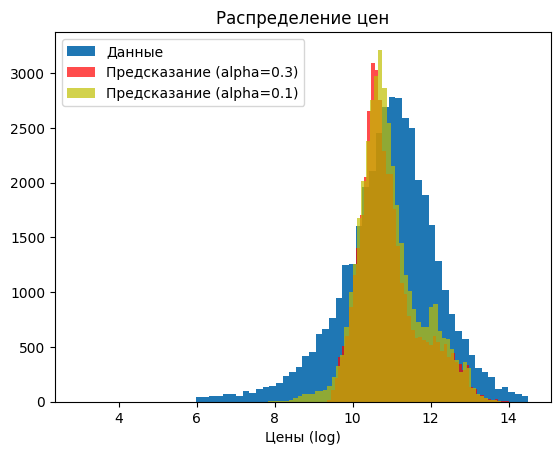

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

def learn_on(train_frame):
    neigh = LinearRegression(fit_intercept=True)
    neigh.fit(train_frame.drop(columns=["per_square_meter_price"]), np.log(train_frame["per_square_meter_price"]))
    return neigh

train, test = train_test_split(df_train, test_size=0.2, random_state=0)
model3 = learn_on(train[signs3])
model2 = learn_on(train[signs2])
model1 = learn_on(train[signs1])
prediction3 = model3.predict(test[signs3].drop(columns=["per_square_meter_price"]))
prediction2 = model2.predict(test[signs2].drop(columns=["per_square_meter_price"]))
prediction1 = model1.predict(test[signs1].drop(columns=["per_square_meter_price"]))
error3 = mean_absolute_percentage_error(test["per_square_meter_price"], np.exp(prediction3))
error2 = mean_absolute_percentage_error(test["per_square_meter_price"], np.exp(prediction2))
error1 = mean_absolute_percentage_error(test["per_square_meter_price"], np.exp(prediction1))
print(f"* Ошибка предсказания на тренировочных данных (alpha=0.3): {error3}")
print(f"* Ошибка предсказания на тренировочных данных (alpha=0.0): {error2}")
print(f"* Ошибка предсказания на тренировочных данных (alpha=0.1): {error1}")

plt.title("Распределение цен")
plt.xlabel("Цены (log)")
plt.hist(np.log(test["per_square_meter_price"]), label="Данные", bins=50)
plt.hist(prediction3, label="Предсказание (alpha=0.3)", bins=50, alpha=0.7, color="r")
plt.hist(prediction1, label="Предсказание (alpha=0.1)", bins=100, alpha=0.7, color="y")
plt.legend(loc="upper left")
plt.show()

df_train = df_train[signs]
model = model1

### Перебор преобразований

Возьмем набор преобразований (логарифмирование, возведение в квадрат, взятие корня) и по очереди применим ко всем колонкам с целью улучшить предсказание.

In [9]:
mapcols = set(filter(lambda c: df_train[c].min() + 1 > 0, df_train.columns))
def maplog(df, c):
    if c not in mapcols:
        return False
    assert df[c].min() + 1 > 0
    df[c] = np.log(df[c] + 1)
    return True
def mapsqr(df, c):
    assert df[c].min() >= 0
    df[c] = df[c] ** 2
    return True
def mapsqrt(df, c):
    assert df[c].min() >= 0
    df[c] = np.sqrt(df[c])
    return True
def mapid(df, c):
    return False

train, test = train_test_split(df_train, test_size=0.2, random_state=0)
bestModel = None
bestModelD = None
bestMappers = None
mappers = {c: mapid for c in train.columns}

def apply_mappers(df):
    df = df.copy()
    for i in df.columns:
        assert i in df.columns
        mappers.get(i, lambda x, y: False)(df, i)
    return df

for c in train.columns:
    if c == "per_square_meter_price":
        continue
    print(f"\n{c}:", end=" ")
    for mp in [mapid, mapsqr, mapsqrt, maplog]:
        oldmp = mappers[c]
        mappers[c] = mp

        model = learn_on(apply_mappers(train))
        split_prediction = model.predict(apply_mappers(test.drop(columns=["per_square_meter_price"])))
        error = mean_absolute_percentage_error(test.per_square_meter_price, np.exp(split_prediction))

        if bestModelD is None or error < bestModelD:
            bestModelD = error
            bestModel = model
            bestMappers = mappers.copy()
            print(f"{mp.__name__}", end=" ")
        else:
            mappers[c] = oldmp


lat: mapid mapsqrt maplog 
lng: mapsqr 
osm_amenity_points_in_0.001: 
osm_amenity_points_in_0.005: 
osm_amenity_points_in_0.0075: 
osm_amenity_points_in_0.01: 
osm_catering_points_in_0.001: maplog 
osm_catering_points_in_0.005: 
osm_catering_points_in_0.0075: mapsqr 
osm_catering_points_in_0.01: 
osm_city_closest_dist: mapsqr 
osm_city_nearest_population: mapsqr 
osm_crossing_points_in_0.001: mapsqr 
osm_crossing_points_in_0.005: 
osm_crossing_points_in_0.0075: 
osm_crossing_points_in_0.01: mapsqr 
osm_culture_points_in_0.001: mapsqr 
osm_culture_points_in_0.005: 
osm_culture_points_in_0.0075: mapsqr 
osm_culture_points_in_0.01: 
osm_finance_points_in_0.001: mapsqr 
osm_finance_points_in_0.005: 
osm_finance_points_in_0.0075: 
osm_finance_points_in_0.01: 
osm_healthcare_points_in_0.005: 
osm_healthcare_points_in_0.0075: 
osm_healthcare_points_in_0.01: 
osm_historic_points_in_0.005: 
osm_historic_points_in_0.0075: 
osm_historic_points_in_0.01: 
osm_hotels_points_in_0.005: mapsqrt 
osm_h

## Предсказание

### Оценка модели

In [10]:
mappers = bestMappers
print(f"* Ошибка модели: {mean_absolute_percentage_error(test.per_square_meter_price, np.exp(split_prediction))}")

* Ошибка модели: 0.9993190934593428


### Предсказание модели на тестовых данных

In [11]:
df_test = pd.read_csv("data/raw/test_x.csv")
df_test = format_df(df_test)

test_prediction = model.predict(apply_mappers(df_test))
df_test["per_square_meter_price"] = test_prediction
df_test.to_csv("data/processed/prediction.csv", columns=["per_square_meter_price"], index=True, index_label="id")
print("* Предсказание записано в 'data/processed/prediction.csv'")

* Предсказание записано в 'data/processed/prediction.csv'
